In [1]:
from __future__ import annotations
import tensorflow_datasets as tfds
import keras_cv

import numpy as np

/opt/miniconda/envs/unet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-20 18:25:22.459281: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 18:25:22.496283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 18:25:22.496304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 18:25:22.497197

Using TensorFlow backend


In [2]:
ds, info = tfds.load("fdf", download=True, with_info=True)

2024-02-20 18:25:25.074128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 18:25:25.109979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 18:25:25.111450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from typing import Optional

from tensorflow_datasets.core import dataset_info
from tensorflow_datasets.core import features as features_lib
from tensorflow_datasets.core import lazy_imports_lib
from tensorflow_datasets.core.utils.lazy_imports_utils import tensorflow as tf
from tensorflow_datasets.core.visualization.visualizer import extract_keys
from tensorflow_datasets.core.visualization.image_visualizer import (
    ImageGridVisualizer,
    _add_image,
    _make_grid,
)


def _draw_bbox(ax, bbox, bbox_format, img_shape):
    patches = lazy_imports_lib.lazy_imports.matplotlib.patches
    bbox = np.floor(np.multiply(bbox, img_shape[0]))
    bbox = keras_cv.bounding_box.convert_format(
        bbox, bbox_format, "xywh", image_shape=img_shape
    )

    ax.add_patch(
        patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor="blue", lw=2
        )
    )


class BBoxVisualizer(ImageGridVisualizer):
    def show(
        self,
        ds: tf.data.Dataset,
        ds_info: dataset_info.DatasetInfo,
        rows: int = 3,
        cols: int = 3,
        plot_scale: float = 3.0,
        bbox_format: str = "xyxy",
        image_key: Optional[str] = None,
        bbox_key: Optional[str] = None,
    ):
        """Display the dataset.

        Args:
          ds: `tf.data.Dataset`. The tf.data.Dataset object to visualize. Examples
            should not be batched. Examples will be consumed in order until (rows *
            cols) are read or the dataset is consumed.
          ds_info: `tfds.core.DatasetInfo` object of the dataset to visualize.
          rows: `int`, number of rows of the display grid.
          cols: `int`, number of columns of the display grid.
          plot_scale: `float`, controls the plot size of the images. Keep this value
            around 3 to get a good plot. High and low values may cause the labels to
            get overlapped.
          image_key: `string`, name of the feature that contains the image. If not
            set, the system will try to auto-detect it.
          label_key: `string`, name of the feature that contains the label. If not
            set, the system will try to auto-detect it.

        Returns:
          fig: The pyplot figure.
        """
        # Extract the image key
        if not image_key:
            image_keys = extract_keys(ds_info.features, features_lib.Image)
            if len(image_keys) > 1:
                raise ValueError(
                    "Multiple image features detected in the dataset. "
                    "Use `image_key` argument to override. Images detected: {}".format(
                        image_keys
                    )
                )
            image_key = image_keys[0]

        if not bbox_key:
            bbox_keys = extract_keys(ds_info.features, features_lib.BBoxFeature)
            if len(bbox_keys) > 1:
                raise ValueError(
                    "Multiple bbox features detected in the dataset. "
                    "Use `bbox_key` argument to override. BBoxes detected: {}".format(
                        bbox_keys
                    )
                )
            bbox_key = bbox_keys[0]

        # Single image display
        def make_cell_fn(ax, ex):
            if not isinstance(ex, dict):
                raise ValueError(
                    "{} requires examples as `dict`, with the same "
                    "structure as `ds_info.features`. It is currently not compatible "
                    "with `as_supervised=True`. Received: {}".format(
                        type(self).__name__, type(ex)
                    )
                )

            _add_image(ax, ex[image_key])

            _draw_bbox(ax, ex[bbox_key], bbox_format, ex[image_key].shape)

        # Returns the grid.
        fig = _make_grid(make_cell_fn, ds, rows, cols, plot_scale)
        return fig

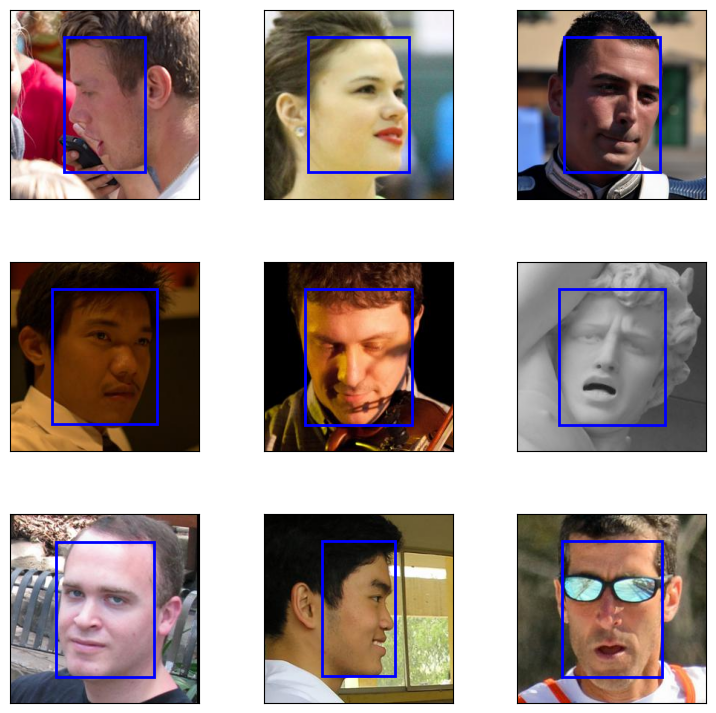

In [6]:
visualizer = BBoxVisualizer()
fig = visualizer.show(ds[""], info)